## Basic Setup

In [ ]:
import os
import sys
import random
import numpy as np
import pandas as pd

import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Flatten, Dense, Reshape, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# modify sys.path for it to contain the main repo path so we can import modules such as below
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from utils.utils import get_root_dir, set_seed, setup_gpu
from utils.data import load_data
from utils.plots import plot_reconstructions, plot_history
from utils.latent_space import extract_latent_representations, apply_tsne, plot_latent_space

# import importlib
# importlib.reload(set_seed)

In [ ]:
# Hyperparameter to tune
config = {
    "comment" : "added dropout to Conv2DTranspose no early stopping",
    "epochs" : 100,
    "loss" : "mae",
    "optimizer" : "adam",
    "dropout" : 0.3,
    "batch_size" : 32,
    "bottle_neck_dim" : 512,
    "threshold_percentage" : 95,
    "data_class" : "screw",
    "model_type" : "autoencoder"
}

# Rather static parameters, no need to track
IMAGE_SIZE = (256, 256)
INPUT_SHAPE = IMAGE_SIZE + (3,)

In [ ]:
root_dir = get_root_dir()

In [4]:
wandb.init(project="itu-aml-project", config=config)
config = wandb.config # this turns our hyperparameter config into a proper object with attributes

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hendrik-spl (itu-aml-project). Use `wandb login --relogin` to force relogin


In [ ]:
model_dir = os.path.join(root_dir, 'models', config.model_type)

cpkt_path = os.path.join(model_dir, 'logs', 'checkpoints', f'{config.comment}_checkpoint.model.keras')
weights_path = os.path.join(model_dir, 'logs', 'weights', f'{config.comment}_model.keras')
assert not os.path.exists(weights_path), f'Path already exists: {weights_path}. Please change the comment.'

In [ ]:
# set the random seeds to make sure that the results are reproducible                                
set_seed(1234)

In [ ]:
setup_gpu()

No GPU found, using CPU.


In [ ]:
train_generator, validation_generator, test_generator = load_data(category=config.data_class, batch_size=config.batch_size)

Found 256 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 160 images belonging to 6 classes.


In [ ]:
def build_autoencoder(input_shape, optimizer, loss, dropout, bottleneck_dim):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (128, 128, 32)
    x = Dropout(dropout)(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (64, 64, 64)+
    x = Dropout(dropout)(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (32, 32, 128)
    x = Dropout(dropout)(x)

    # Bottleneck
    x = Flatten()(x)                        # Flattened Shape: (32 * 32 * 128,)
    encoded = Dense(bottleneck_dim)(x)      # Latent space size reduced to 512
    encoded = BatchNormalization()(encoded)
    encoded = LeakyReLU(name='bottleneck')(encoded)

    # Decoder
    x = Dense(32 * 32 * 128)(encoded)
    x = Reshape((32, 32, 128))(x)

    # x = UpSampling2D((2, 2))(x)  # (64, 64, 128)
    # x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x) # (64, 64, 128)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(dropout)(x)

    # x = UpSampling2D((2, 2))(x)  # (128, 128, 64)
    # x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x) # (128, 128, 64)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(dropout)(x)

    # x = UpSampling2D((2, 2))(x)  # (256, 256, 32)
    # x = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x) # (256, 256, 32)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(dropout)(x)

    x = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, x)
    autoencoder.compile(
        optimizer=optimizer,
        loss=loss
        )
    
    return autoencoder

autoencoder = build_autoencoder(input_shape=INPUT_SHAPE, optimizer=config.optimizer, loss=config.loss, dropout=config.dropout, bottleneck_dim=config.bottle_neck_dim)

## Potential Improvements highlighted by ChatGPT

- MaxPooling and UpSampling Inconsistency:
    - The encoder progressively reduces the spatial dimensions using MaxPooling2D. However, the decoder uses UpSampling2D for reconstruction, which is a deterministic upscaling method. This may lead to “checkerboard artifacts” in the reconstructed image.
    - Consider using learned upsampling layers such as Conv2DTranspose instead of UpSampling2D.

- Loss Function Mismatch:
    - The final activation in the decoder is sigmoid, which is appropriate for normalizing pixel values in the range [0, 1]. However, the loss function should align with this.
	- If you’re using mean squared error (MSE) or mean absolute error (MAE), these may not work as well for binary-like pixel values.
	- Consider using binary_crossentropy or Kullback-Leibler divergence (if appropriate) when working with sigmoid outputs.

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss", 
    mode="min",
    patience=10,
    start_from_epoch=10
    )

checkpoint = ModelCheckpoint(
    cpkt_path, 
    monitor="val_loss", 
    mode="min", 
    save_best_only=True, 
    verbose=1
    )

In [11]:
history = autoencoder.fit(
    train_generator,
    epochs=config.epochs,
    validation_data=validation_generator,
    callbacks=[
        # early_stop,
        checkpoint,
        WandbMetricsLogger(),
        # WandbModelCheckpoint("models"), # Saves model checkpoint to W&B
    ],
)

wandb.finish()

/Users/hendriksippel/Documents/Repositories/itu-aml-anomaly-detection/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2551
Epoch 1: val_loss improved from inf to 0.45188, saving model to /Users/hendriksippel/Documents/Repositories/itu-aml-anomaly-detection/models/autoencoder/logs/checkpoints/added dropout to Conv2DTranspose no early stopping_checkpoint.model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 79s 9s/step - loss: 0.2519 - val_loss: 0.4519
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.1567
Epoch 2: val_loss improved from 0.45188 to 0.26241, saving model to /Users/hendriksippel/Documents/Repositories/itu-aml-anomaly-detection/models/autoencoder/logs/checkpoints/added dropout to Conv2DTranspose no early stopping_checkpoint.model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 75s 9s/step - loss: 0.1552 - val_loss: 0.2624
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.1054
Epoch 3: val_loss improved from 0.26241 to 0.18963, saving model to /Users/hendriksippel/Documents/Repositories/itu-aml-anomaly-detection/models/autoencoder/logs/checkpoints/add

epoch/epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,99
epoch/learning_rate,0.001
epoch/loss,0.02281
epoch/val_loss,0.02285


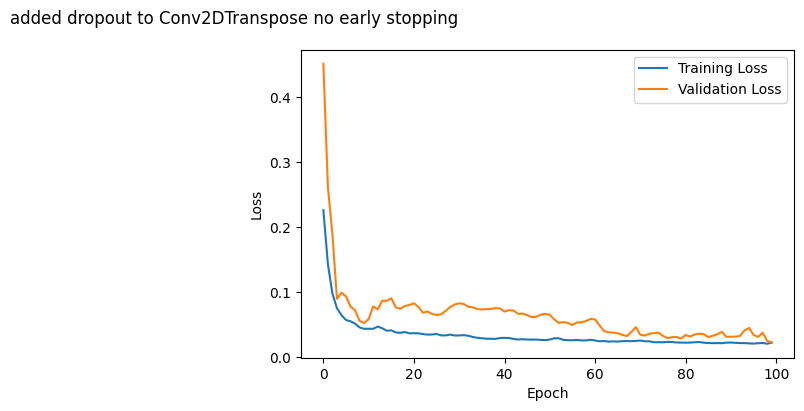

Best train_loss: 0.021
Best val_loss: 0.0229
Last improvement of val_loss at epoch: 1


In [12]:
# plot the training history
plot_history(comment=config.comment, history=history)

In [ ]:
# load the best model
autoencoder.load_weights(cpkt_path)

# save the model
autoencoder.save(weights_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


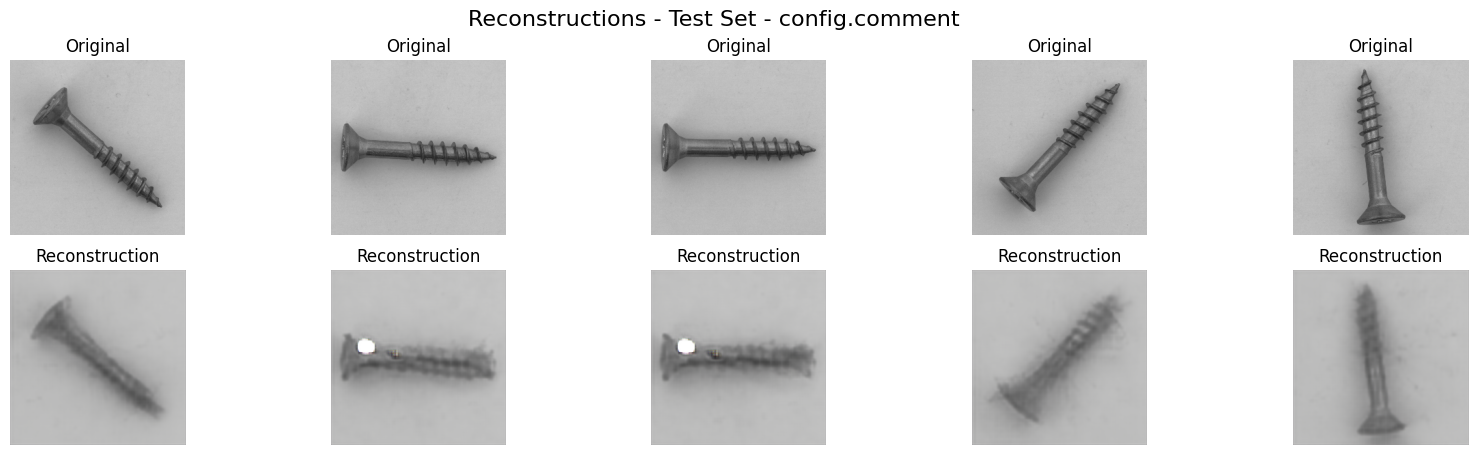

In [ ]:
plot_reconstructions(autoencoder, test_generator, n_images=5, title=f"Reconstructions - Test Set - {config.comment}")

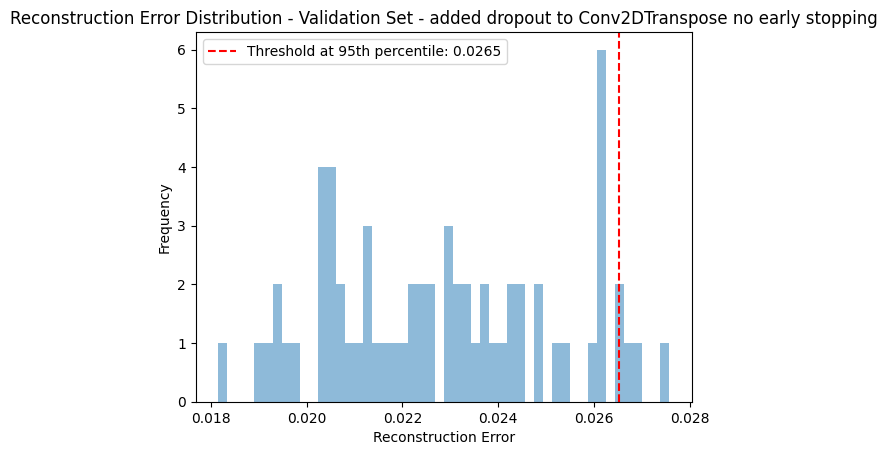

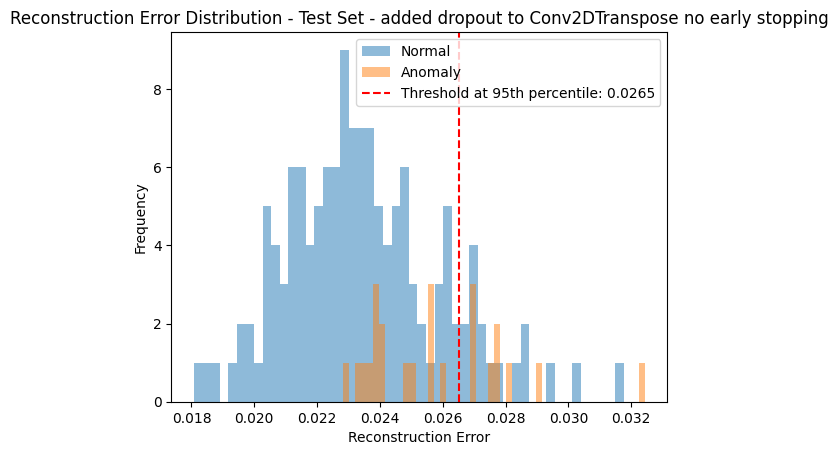

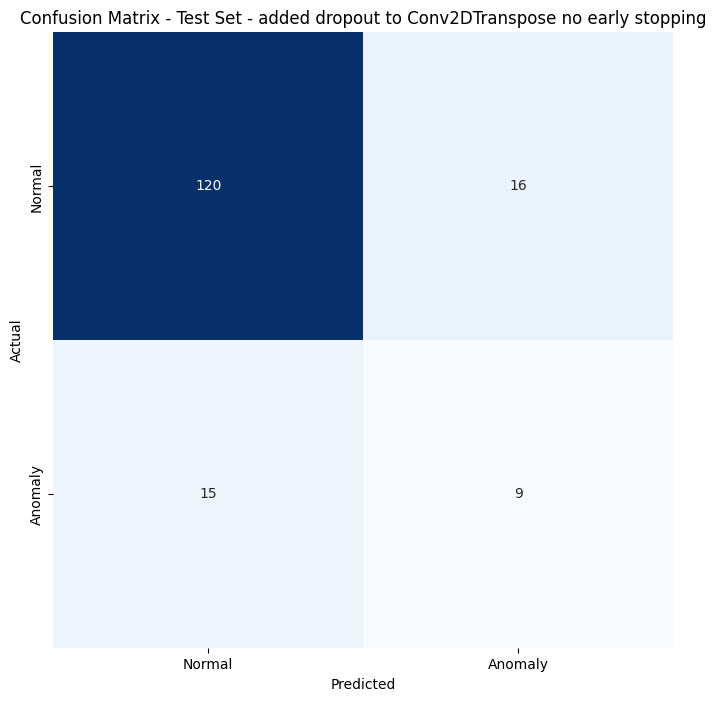

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple

def calculate_error(images: np.ndarray, reconstructions: np.ndarray, loss_function: str) -> List[float]:
    """
    Calculate error between original images and their reconstructions.

    Parameters:
    images (np.ndarray): The original images.
    reconstructions (np.ndarray): The reconstructed images.
    loss_function (str): The loss function to use ('mae' or 'mse').

    Returns:
    List[float]: A list of errors.
    """
    if loss_function == 'mae':
        return np.mean(np.abs(reconstructions - images), axis=(1, 2, 3))
    elif loss_function == 'mse':
        return np.mean(np.square(reconstructions - images), axis=(1, 2, 3))
    else:
        raise ValueError(f"Unknown loss function: {loss_function}. Please define a function to calculate the error.")

def get_errors_and_labels(autoencoder: Model, generator: ImageDataGenerator, loss_function: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculate errors and true labels.

    Parameters:
    autoencoder (Model): The autoencoder model.
    generator (ImageDataGenerator): The test data generator.
    loss_function (str): The loss function to use ('mae' or 'mse').

    Returns:
    Tuple[np.ndarray, np.ndarray]: Arrays of test errors and true labels.
    """
    errors = []
    labels = []
    for i in range(len(generator)):
        batch_images, batch_labels = next(generator)
        reconstructions = autoencoder.predict(batch_images, verbose=0)
        batch_errors = calculate_error(batch_images, reconstructions, loss_function)
        errors.extend(batch_errors)
        labels.extend(batch_labels[:, 1])
    return np.array(errors), np.array(labels)

def get_threshold(errors: np.ndarray, percentage: int) -> float:
    """
    Calculate the threshold based on the errors.

    Parameters:
    errors (List[float]): The errors.
    percentage (int): The percentile to use for the threshold.

    Returns:
    float: The calculated threshold.
    """
    return np.percentile(errors, percentage)

def plot_single_histogram_with_threshold(errors: List[float], threshold: float, title: str, xlabel: str, ylabel: str, threshold_label: str) -> None:
    """
    Plot a single histogram with a threshold line.

    Parameters:
    errors (List[float]): The errors to plot.
    threshold (float): The threshold value.
    title (str): The title of the plot.
    xlabel (str): The label for the x-axis.
    ylabel (str): The label for the y-axis.
    threshold_label (str): The label for the threshold line.
    """
    plt.hist(errors, bins=50, alpha=0.5)
    plt.axvline(threshold, color='r', linestyle='--', label=threshold_label)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def plot_double_histogram_with_threshold(normal_errors: List[float], anomaly_errors: List[float], threshold: float, title: str, xlabel: str, ylabel: str, threshold_label: str) -> None:
    """
    Plot two histograms (normal and anomaly errors) with a threshold line.

    Parameters:
    normal_errors (List[float]): The normal errors to plot.
    anomaly_errors (List[float]): The anomaly errors to plot.
    threshold (float): The threshold value.
    title (str): The title of the plot.
    xlabel (str): The label for the x-axis.
    ylabel (str): The label for the y-axis.
    threshold_label (str): The label for the threshold line.
    """
    plt.hist(normal_errors, bins=50, alpha=0.5, label='Normal')
    plt.hist(anomaly_errors, bins=50, alpha=0.5, label='Anomaly')
    plt.axvline(threshold, color='r', linestyle='--', label=threshold_label)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def plot_confusion_matrix(confusion_matrix: np.ndarray, labels: List[str], title: str) -> None:
    """
    Plot a confusion matrix.

    Parameters:
    confusion_matrix (np.ndarray): The confusion matrix to plot.
    labels (List[str]): The labels for the confusion matrix.
    title (str): The title of the plot.
    """
    plt.figure(figsize=(8, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def evaluate_autoencoder(autoencoder: Model, validation_generator: ImageDataGenerator, test_generator: ImageDataGenerator) -> None:
    """
    Evaluate the autoencoder model.

    Parameters:
    autoencoder (Model): The autoencoder model.
    validation_generator (ImageDataGenerator): The validation data generator.
    test_generator (ImageDataGenerator): The test data generator.
    """
    ground_truth_labels = [
        "Normal", # 0
        "Anomaly" # 1
        ]

    # Step 1: Calculate reconstruction error on the validation set
    validation_errors, _ = get_errors_and_labels(
        autoencoder=autoencoder, 
        generator=validation_generator, 
        loss_function=config.loss
    )

    # Step 2: Calculate threshold based on the reconstruction error
    threshold = get_threshold(
        errors=validation_errors, 
        percentage=config.threshold_percentage
    )

    # Step 3: Plot error distribution with threshold
    plot_single_histogram_with_threshold(
        errors=validation_errors,
        threshold=threshold,
        title=f"Reconstruction Error Distribution - Validation Set - {config.comment}",
        xlabel="Reconstruction Error",
        ylabel="Frequency",
        threshold_label=f"Threshold at {config.threshold_percentage}th percentile: {threshold:.4f}",
    )

    # Step 4: Calculate test errors and labels
    test_errors, true_labels = get_errors_and_labels(
        autoencoder=autoencoder, 
        generator=test_generator, 
        loss_function=config.loss
    )

    # Step 5: Adjust true labels to match the class indices
    true_labels = np.where(true_labels == test_generator.class_indices["good"], 0, 1)

    # Step 6: Predict labels based on the threshold
    predicted_labels = np.where(test_errors > threshold, 1, 0)

    # Step 7: Calculate metrics
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Step 8: Split errors based on the true labels
    normal_errors = test_errors[true_labels == 0]
    anomalous_errors = test_errors[true_labels == 1]

    # Step 9: Plot error distribution for normal and anomalous samples
    plot_double_histogram_with_threshold(
        normal_errors,
        anomalous_errors,
        threshold,
        f"Reconstruction Error Distribution - Test Set - {config.comment}",
        "Reconstruction Error",
        "Frequency",
        f"Threshold at {config.threshold_percentage}th percentile: {threshold:.4f}",
    )

    # Step 10: Plot confusion matrix
    plot_confusion_matrix(conf_matrix, ground_truth_labels, f"Confusion Matrix - Test Set - {config.comment}")

evaluate_autoencoder(
    autoencoder=autoencoder,
    validation_generator=validation_generator,
    test_generator=test_generator
    )

/var/folders/4v/mg6gp3rx0yj803ddxqcd01bc0000gn/T/ipykernel_12820/1743447053.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', num_classes)


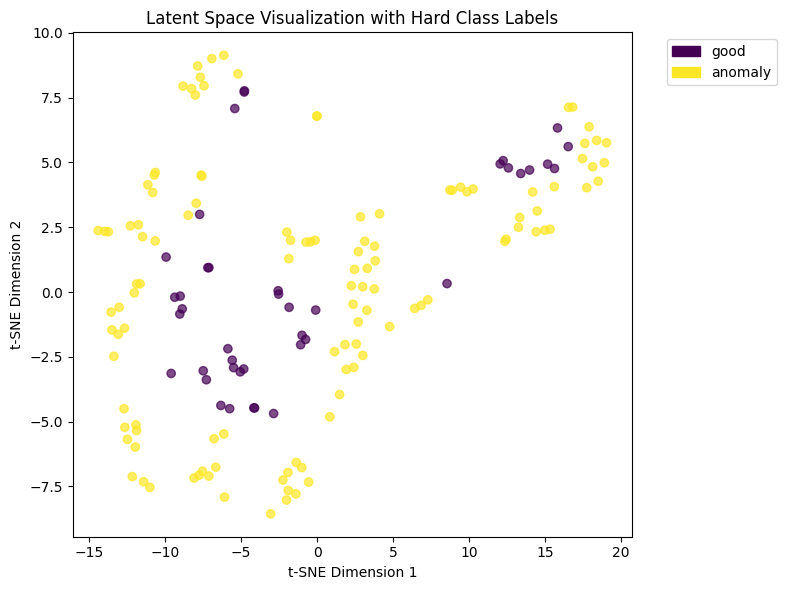

In [ ]:
class_indices = {'good': 0, 'anomaly': 1}

# Step 1: Extract latent representations
latent_representations, labels_indices = extract_latent_representations(autoencoder, test_generator)

# Step 2: Apply t-SNE
latent_2d = apply_tsne(latent_representations)

# Step 3: Plot latent space
plot_latent_space(latent_2d, labels_indices, class_indices)